# Inception V3

### InceptionV3 with TI-RADS

## Get packages

In [58]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm
import albumentations as A 
import cv2

from skimage.io import imread
from skimage.io import imshow
from skimage.util import crop
from skimage.transform import resize
import matplotlib.pyplot as plt


from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras import models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import regularizers


## Paths

In [172]:
TRAIN_PATH = 'archive/classification/tirads/no_frame/balance/train'
TEST_PATH = 'archive/classification/tirads/no_frame/balance/test'
VALID_PATH = 'archive/classification/tirads/no_frame/balance/validate 2'

In [173]:
input_size = (3,150,150)

## Load and Prepare Images

In [174]:
# # for neaug frame
# # divisible with 258: 2, 3, 6, 43, 86, 129 
# train_batchsize = 6
# # divisible with 52: 2, 4, 13 
# valid_batchsize = 4


# #for aug frame
# # divisible with 518: 2, 259.
# train_batchsize = 2
# # divisible with 52: 2, 4, 13 
# valid_batchsize = 4


# #for balance frame
# # divisible with 426: 2, 3, 6, 71, 142, 213
# train_batchsize = 6
#  # divisible with 52: 2, 4, 13 
# valid_batchsize = 4


# # for neaug no frame
# # divisible with 258: 2, 3, 6, 43, 86, 129 
# train_batchsize = 6
# # divisible with 52: 2, 4, 13 
# valid_batchsize = 4


# #for aug no frame
# # divisible with 518: 2, 259
# train_batchsize = 2
# # divisible with 52: 2, 4, 13 
# valid_batchsize = 4


#for balance no frane
# divisible with 426: 2, 3, 6, 71, 142, 213
train_batchsize = 6
#  # divisible with 52: 2, 4, 13 
valid_batchsize = 4


train_datagen = ImageDataGenerator(
        rescale = 1./255.,

)

validation_datagen = ImageDataGenerator(
        rescale = 1./255.,
    )
                                  

train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,  
        shuffle=True,
#          batch_size=train_batchsize,
        target_size = input_size[1:],
        class_mode='categorical')  

validation_generator = validation_datagen.flow_from_directory(
        VALID_PATH,  
        target_size = input_size[1:],
        shuffle=True,
#          batch_size=valid_batchsize,
        class_mode='categorical')

Found 426 images belonging to 6 classes.
Found 52 images belonging to 6 classes.


## Make the model

In [175]:

from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

In [176]:
# from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(base_model)

model.add(Flatten())
model.add(Dense(1024, kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))  # Dropout for regularization

# Add a final sigmoid layer with 1 node for classification output
model.add(Dense(6, activation='softmax'))
# Print a summary of the model architecture
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_16 (Flatten)        (None, 18432)             0         
                                                                 
 dense_32 (Dense)            (None, 1024)              18875392  
                                                                 
 activation_1520 (Activatio  (None, 1024)              0         
 n)                                                              
                                                                 
 dropout_16 (Dropout)        (None, 1024)              0         
                                                                 
 dense_33 (Dense)            (None, 6)                 6150      
                                                     

In [177]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
#     loss=keras.losses.BinaryCrossentropy(),
     optimizer=keras.optimizers.legacy.Adamax(learning_rate=0.001),  
#     optimizer=keras.optimizers.legacy.RMSprop(learning_rate=0.001,decay=1e-3, momentum=0.9),
    metrics = ['accuracy']
    )

## Train the model

In [178]:
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.Variable) or tf.is_tensor(lr):
            lr = tf.keras.backend.get_value(lr)
        print(f" Epoch {epoch+1}: Learning rate is {lr:.6f}")

In [179]:
# Saving the best result
checkpoiter = tf.keras.callbacks.ModelCheckpoint('model_inception_tirads_aug.h5', verbose=1, save_best_only=True)

steps = train_generator.samples//train_generator.batch_size
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=4, min_lr=0.00001, verbose=1)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
     reduce_lr,
    LearningRateLogger(),
    checkpoiter

]
# Train
results = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    validation_steps=validation_generator.samples // validation_generator.batch_size,
                    steps_per_epoch = steps,
                    shuffle=True,
                    epochs=50, 
                    callbacks=callbacks,
                   )

Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 20.7847 - accuracy: 0.2386 Epoch 1: Learning rate is 0.001000

Epoch 1: val_loss improved from inf to 16.40519, saving model to model_inception_tirads_aug.h5


/Users/taras_lara/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 81s 4s/step - loss: 20.7847 - accuracy: 0.2386 - val_loss: 16.4052 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 13.5867 - accuracy: 0.5127 Epoch 2: Learning rate is 0.001000

Epoch 2: val_loss improved from 16.40519 to 13.68821, saving model to model_inception_tirads_aug.h5
13/13 [==============================] - 37s 3s/step - loss: 13.5867 - accuracy: 0.5127 - val_loss: 13.6882 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 10.9943 - accuracy: 0.7360 Epoch 3: Learning rate is 0.001000

Epoch 3: val_loss improved from 13.68821 to 12.17558, saving model to model_inception_tirads_aug.h5
13/13 [==============================] - 38s 3s/step - loss: 10.9943 - accuracy: 0.7360 - val_loss: 12.1756 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 9.4179 - accuracy: 0.8807 Epoch 4: Lea

13/13 [==============================] - 42s 3s/step - loss: 6.1792 - accuracy: 0.9975 - val_loss: 9.3646 - val_accuracy: 0.0938 - lr: 1.0000e-05
Epoch 25/50
13/13 [==============================] - ETA: 0s - loss: 6.1769 - accuracy: 1.0000 Epoch 25: Learning rate is 0.000010

Epoch 25: val_loss did not improve from 8.42067
13/13 [==============================] - 40s 3s/step - loss: 6.1769 - accuracy: 1.0000 - val_loss: 8.7493 - val_accuracy: 0.1562 - lr: 1.0000e-05
Epoch 26/50
13/13 [==============================] - ETA: 0s - loss: 6.1746 - accuracy: 0.9924 Epoch 26: Learning rate is 0.000010

Epoch 26: val_loss did not improve from 8.42067
13/13 [==============================] - 35s 3s/step - loss: 6.1746 - accuracy: 0.9924 - val_loss: 9.1520 - val_accuracy: 0.0938 - lr: 1.0000e-05
Epoch 27/50
13/13 [==============================] - ETA: 0s - loss: 6.1566 - accuracy: 1.0000 Epoch 27: Learning rate is 0.000010

Epoch 27: val_loss did not improve from 8.42067
13/13 [===============

13/13 [==============================] - 38s 3s/step - loss: 6.0059 - accuracy: 1.0000 - val_loss: 8.7743 - val_accuracy: 0.1250 - lr: 1.0000e-05
Epoch 50/50
13/13 [==============================] - ETA: 0s - loss: 5.9974 - accuracy: 0.9949 Epoch 50: Learning rate is 0.000010

Epoch 50: val_loss did not improve from 8.35437
13/13 [==============================] - 32s 2s/step - loss: 5.9974 - accuracy: 0.9949 - val_loss: 8.5084 - val_accuracy: 0.1875 - lr: 1.0000e-05


## Results

In [180]:
print('Accuracy Score = ',np.max(results.history['val_accuracy']))
print('Loss Score = ',np.min(results.history['val_loss']))

Accuracy Score =  0.28125
Loss Score =  8.354373931884766


### During training

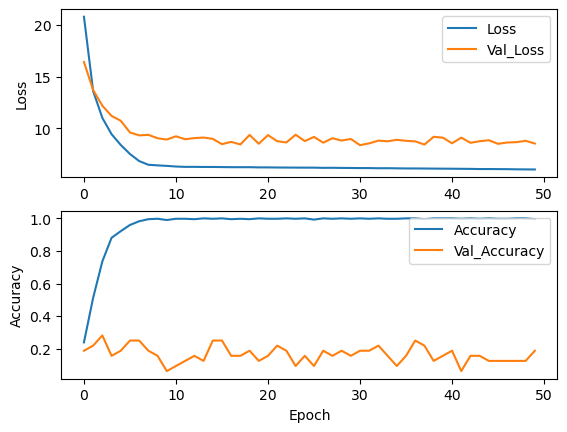

In [181]:
plt.figure()
plt.subplot(211)
loss_train_curve = results.history["loss"]
loss_val_curve = results.history["val_loss"]
plt.plot(loss_train_curve, label = "Loss")
plt.plot(loss_val_curve, label = "Val_Loss")
plt.legend(loc = 'upper right')
plt.ylabel("Loss")


plt.subplot(212)
acc_train_curve = results.history["accuracy"]
acc_val_curve = results.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Accuracy")
plt.plot(acc_val_curve, label = "Val_Accuracy")
plt.legend(loc = 'upper right')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

## Test the model

In [182]:
# Predict Classes

# divisible with 36:  2, 3, 4, 6, 9, 12, 18
test_batch_size = 6

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=input_size[1:],
    batch_size=test_batch_size,
    shuffle=False,
class_mode='categorical')
scores = model.evaluate(test_generator,workers=12)
print(scores)
target_names = list(test_generator.class_indices.keys())

Found 36 images belonging to 6 classes.
6/6 [==============================] - 4s 699ms/step - loss: 8.4816 - accuracy: 0.1944
[8.481613159179688, 0.1944444477558136]


### Make prediction

In [184]:
test_generator.reset()

Y_pred = model.predict(test_generator, verbose=1)

y_pred = np.argmax(Y_pred, axis=-1)
classes = test_generator.classes

print(classes)
print(y_pred)

print(sum(y_pred==classes)/len(test_generator.classes))

6/6 [==============================] - 2s 381ms/step
[0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 5 5 5 5 5]
[3 0 0 2 4 2 2 4 3 2 4 5 5 1 0 5 4 4 2 0 0 2 3 4 4 3 5 3 5 4 3 4 4 3 2 5]
0.19444444444444445


### Confusion Matrix

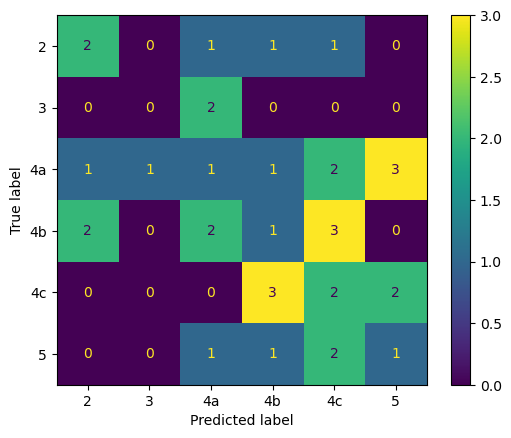

In [185]:
cm = confusion_matrix(classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot()
plt.grid(False)
plt.show()

### Metrics

In [186]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

In [187]:
def Average(FP):
    return sum(FP) / len(FP)
FP=Average(FP)

def Average1(FN):
    return sum(FN) / len(FN)
FN=Average1(FN)

def Average2(TP):
    return sum(TP) / len(TP)
TP=Average2(TP)

def Average3(TN):
    return sum(TN) / len(TN)
TN=Average3(TN)


print("True positive=",TP)
print("True Negative=",TN)
print("False positive=",FP)
print("False Negative=",FN)

True positive= 1.1666666666666667
True Negative= 25.166666666666668
False positive= 4.833333333333333
False Negative= 4.833333333333333


In [188]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
#F1_SCORE
FSCO=(2*TP) / ((2*TP) +FP + FN) 
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [189]:
print("sensitivity=",round(TPR*100,3),"%")
print("precision=",round(PPV*100,3),"%")
print("Specificity=",round(TNR*100,3),"%")
print("F-score=",round(FSCO*100,3),"%")
print("ACCURACY=",round(ACC*100,3),"%")
print("FNR=",FNR*100,"%")
print("FPR=",FPR*100,"%")
print("NPV=",NPV*100,"%")

sensitivity= 19.444 %
precision= 19.444 %
Specificity= 83.889 %
F-score= 19.444 %
ACCURACY= 73.148 %
FNR= 80.55555555555554 %
FPR= 16.11111111111111 %
NPV= 83.88888888888889 %
